# Model Run: Pair learning
Version 1  
Low

Version 2  
Pregenerate list pair dataset

Version 3  
Using contrastive loss. 

Version 6  
Wait! we did not check the training preds. 

## Import Libs

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB


from model_model import SiameseNetworkV2
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp
from model_dataset import Padder, DS_Tools, NormalizerKeepShape, Normalizer
from model_dataset import PairRecDatasetPregenPrecombine as ThisDataset
from model_loss import ContrastiveLoss, calculate_mean_ci
from model_filter import XpassFilter
from paths import *
from ssd_paths import *
from misc_progress_bar import draw_progress_bar
from misc_recorder import *

## Configure READ

In [2]:
READ = False

## Get Timestamp

In [3]:
if READ: 
    ts = "1113221926"
else: 
    ts = str(get_timestamp())
    # ts = "1120210536"

train_name = "rnn-pair-original"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

rnn-pair-original-1128114539


In [4]:
stop_epoch = "99"
save_trainhist_name = "train.hst"
save_valhist_name = "val.hst"
# save_valprec_name = "valprec.hst"
# save_valrec_name = "valrec.hst"
# save_valf_name = "valf.hst"
val_same_name = "valsame.csv"
val_diff_name = "valdiff.csv"
train_same_name = "trainsame.csv"
train_diff_name = "traindiff.csv"

## Prepare Loss Recording

In [35]:
train_losses = ListRecorder(os.path.join(model_save_dir, save_trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, save_valhist_name))

valid_same = DfRecorder(os.path.join(model_save_dir, val_same_name))
valid_diff = DfRecorder(os.path.join(model_save_dir, val_diff_name))
train_same = DfRecorder(os.path.join(model_save_dir, train_same_name))
train_diff = DfRecorder(os.path.join(model_save_dir, train_diff_name))
# valid_precs = ListRecorder(os.path.join(model_save_dir, save_valprec_name))
# valid_recs = ListRecorder(os.path.join(model_save_dir, save_valrec_name))
# valid_fs = ListRecorder(os.path.join(model_save_dir, save_valf_name))

## Prepare Dataset

In [36]:
class SqueezeAndTranspose(nn.Module): 
    def __init__(self): 
        super().__init__()

    def forward(self, spectrogram): 
        spectrogram = spectrogram.squeeze()
        spectrogram = spectrogram.permute(1, 0) # (F, L) -> (L, F)
        return spectrogram

In [34]:
# mytrans = MelSpecTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
#                             n_fft=TrainingConfigs.N_FFT, 
#                             n_mels=TrainingConfigs.N_MELS, 
#                             norm="strip_mvn")  # filter=XpassFilter(cut_off_upper=500)
mytrans = nn.Sequential(
    # Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
    MelSpectrogram(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
                   n_mels=TrainingConfigs.N_MELS, 
                   n_fft=TrainingConfigs.N_FFT, power=2), 
    AmplitudeToDB(stype="power", top_db=80), 
    SqueezeAndTranspose(),
    Normalizer(Normalizer.norm_mvn)
)
train_ds = ThisDataset(strain_cut_audio_, os.path.join(suse_, "guide_train.csv"), 
                 list_save_dir=os.path.join(model_save_dir, "train_paired_list.csv"), 
                 total_number=30000, transform=mytrans)

valid_ds = ThisDataset(strain_cut_audio_, os.path.join(suse_, "guide_validation.csv"), 
                 list_save_dir=os.path.join(model_save_dir, "valid_paired_list.csv"), 
                 total_number=3000, transform=mytrans)

# if not READ: 
#     # use_len = int(0.01 * len(ds))
#     # remain_len = len(ds) - use_len
#     # use_ds, remain_ds = random_split(ds, [use_len, remain_len])
#     use_ds = ds

#     train_len = int(0.8 * len(use_ds))
#     valid_len = len(use_ds) - train_len

#     # Randomly split the dataset into train and validation sets
#     train_ds, valid_ds = random_split(use_ds, [train_len, valid_len])

#     # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
#     # the saved train and valid separations will reflect this
#     DS_Tools.save_indices(os.path.join(model_save_dir, "train.data"), train_ds.indices)
#     DS_Tools.save_indices(os.path.join(model_save_dir, "valid.data"), valid_ds.indices)
# else: 
#     train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.data"))
#     valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.data"))

#     train_ds = torch.utils.data.Subset(ds, train_ds_indices)
#     valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

train_loader = DataLoader(train_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=TrainingConfigs.LOADER_WORKER, 
                          collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)
print(train_num, valid_num)

30000 3000


## Init Model

In [17]:
i1 = torch.rand(1, 4)
i2 = torch.rand(1, 4)
criterion = ContrastiveLoss(margin=0.9)
criterion(i1, i1, 1), criterion(i1, i2, 0) # criterion(i1, i1, 0), criterion(i1, i2, 1)

(tensor(0.8100), tensor(0.1579))

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# criterion = nn.MSELoss()
criterion = ContrastiveLoss(margin=0.9)
# NOTE: no need to mask the loss, because we don't do reconstruction. 

dimconf = ModelDimConfigs(
        rnn_in_size=TrainingConfigs.N_MELS, 
        lin_in_size_1=16, 
        lin_in_size_2=8, 
        lin_out_size_2=4
    )

model = SiameseNetworkV2(
    dimconf=dimconf, 
    num_layers=2
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

In [38]:
model

SiameseNetworkV2(
  (rnn): SelfPackLSTM(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (extract): LastElementExtractor()
  )
  (fc): Sequential(
    (0): Tanh()
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Load Model if READ

In [39]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [40]:
# def draw_learning_curve_and_dissimilarity(losses, dissimilarities, epoch="", save=False, save_name=""): 
#     plt.clf()
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#     train_losses, valid_losses, best_val_loss = losses
#     same_dict, diff_dict, (draw_low, draw_up) = dissimilarities

#     # Plot Loss on the left subplot
#     ax1.plot(train_losses, label='Train')
#     ax1.plot(valid_losses, label='Valid')
#     ax1.axvline(x=best_val_loss, color='r', linestyle='--', label=f'Best: {best_val_loss}')
#     ax1.set_title("Learning Curve Loss" + f" {epoch}")
#     ax1.legend(loc="upper right")

#     # Plot Accuracy on the right subplot
#     time_steps = np.arange(draw_low, draw_up)
#     ax2.errorbar(time_steps, same_dict["mean"][draw_low:draw_up], 
#                  yerr=(same_dict["mean"][draw_low:draw_up] - same_dict["ci_lower"][draw_low:draw_up], same_dict["ci_upper"][draw_low:draw_up] - same_dict["mean"][draw_low:draw_up]), 
#                  label='Same', fmt='o-', capsize=5)
#     ax2.errorbar(time_steps, diff_dict["mean"][draw_low:draw_up], 
#                  yerr=(diff_dict["mean"][draw_low:draw_up] - diff_dict["ci_lower"][draw_low:draw_up], diff_dict["ci_upper"][draw_low:draw_up] - diff_dict["mean"][draw_low:draw_up]), 
#                  label='Different', fmt='o-', capsize=5)
#     ax2.set_title('Learning Curve Dissimilarity' + f" {epoch}")
#     ax2.legend()    # loc="lower right"

#     # Display the plots
#     plt.tight_layout()
#     plt.xlabel("Epoch")
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     if save: 
#         plt.savefig(save_name)

def draw_learning_curve_and_dissimilarity(losses, dissimilarities, epoch="", save=False, save_name=""): 
    plt.clf()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    train_losses, valid_losses, best_val_loss = losses
    # NOTE: !
    train_same_dict, train_diff_dict, same_dict, diff_dict, (draw_low, draw_up) = dissimilarities

    # Plot Loss on the left subplot
    ax1.plot(train_losses, label='Train')
    ax1.plot(valid_losses, label='Valid')
    ax1.axvline(x=best_val_loss, color='r', linestyle='--', label=f'Best: {best_val_loss}')
    ax1.set_title("Learning Curve Loss" + f" {epoch}")
    ax1.legend(loc="upper right")

    # Plot Accuracy on the right subplot
    time_steps = np.arange(draw_low, draw_up)
    ax2.errorbar(time_steps, same_dict["mean"][draw_low:draw_up], 
                 yerr=(same_dict["mean"][draw_low:draw_up] - same_dict["ci_lower"][draw_low:draw_up], same_dict["ci_upper"][draw_low:draw_up] - same_dict["mean"][draw_low:draw_up]), 
                 label='Same', fmt='o-', capsize=5)
    ax2.errorbar(time_steps, diff_dict["mean"][draw_low:draw_up], 
                 yerr=(diff_dict["mean"][draw_low:draw_up] - diff_dict["ci_lower"][draw_low:draw_up], diff_dict["ci_upper"][draw_low:draw_up] - diff_dict["mean"][draw_low:draw_up]), 
                 label='Different', fmt='o-', capsize=5)
    ax2.set_title('Learning Curve Valid Dissimilarity' + f" {epoch}")
    ax2.legend()    # loc="lower right"

    # Plot Accuracy on the right subplot
    time_steps = np.arange(draw_low, draw_up)
    ax3.errorbar(time_steps, train_same_dict["mean"][draw_low:draw_up], 
                 yerr=(train_same_dict["mean"][draw_low:draw_up] - train_same_dict["ci_lower"][draw_low:draw_up], train_same_dict["ci_upper"][draw_low:draw_up] - train_same_dict["mean"][draw_low:draw_up]), 
                 label='Same', fmt='o-', capsize=5)
    ax3.errorbar(time_steps, train_diff_dict["mean"][draw_low:draw_up], 
                 yerr=(train_diff_dict["mean"][draw_low:draw_up] - train_diff_dict["ci_lower"][draw_low:draw_up], train_diff_dict["ci_upper"][draw_low:draw_up] - train_diff_dict["mean"][draw_low:draw_up]), 
                 label='Different', fmt='o-', capsize=5)
    ax3.set_title('Learning Curve Train Dissimilarity' + f" {epoch}")
    ax3.legend()    # loc="lower right"

    # Display the plots
    plt.tight_layout()
    plt.xlabel("Epoch")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if save: 
        plt.savefig(save_name)

In [41]:
best_valid_loss = 1e9
best_valid_loss_epoch = 0

In [42]:
EPOCHS = 30
BASE = 0

In [43]:
def train(best_valid_loss, best_valid_loss_epoch): 
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        train_dissimilarities = []
        train_targets = []
        for idx, ((x_1, x_1_lens), (x_2, x_2_lens), y) in enumerate(train_loader):
            optimizer.zero_grad()
            
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            y = torch.tensor(y, device=device, dtype=torch.float32)

            o1, o2 = model((x_1, x_2), (x_1_lens, x_2_lens))
            # y_hat = y_hat.squeeze(dim=1)
            loss = criterion(o1, o2, y)
            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            euclidean_distance = F.pairwise_distance(o1.clone().detach(), o2.clone().detach(), keepdim = False)
            train_dissimilarities += euclidean_distance.cpu().tolist()
            train_targets += y.cpu().tolist()

            draw_progress_bar(idx, train_num, title="Train")

        train_losses.append(train_loss / train_num)
        train_same_preds, train_diff_preds = calculate_mean_ci(train_dissimilarities, train_targets)
        train_same.append(train_same_preds)
        train_diff.append(train_diff_preds)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        valid_dissimilarities = []
        valid_targets = []
        for idx, ((x_1, x_1_lens), (x_2, x_2_lens), y) in enumerate(valid_loader):
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            y = torch.tensor(y, device=device, dtype=torch.float32)

            o1, o2 = model((x_1, x_2), (x_1_lens, x_2_lens))
            # y_hat = y_hat.squeeze(dim=1)
            loss = criterion(o1, o2, y)
            valid_loss += loss.item()

            euclidean_distance = F.pairwise_distance(o1.clone().detach(), o2.clone().detach(), keepdim = False)

            # pred = model.predict_on_output(o1, o2)

            valid_dissimilarities += euclidean_distance.cpu().tolist()
            valid_targets += y.cpu().tolist()

            draw_progress_bar(idx, valid_num, title="Valid")

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        valid_same_preds, valid_diff_preds = calculate_mean_ci(valid_dissimilarities, valid_targets)
        valid_same.append(valid_same_preds)
        valid_diff.append(valid_diff_preds)
        
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve_and_dissimilarity(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                         dissimilarities=(train_same.get(), train_diff.get(), valid_same.get(), valid_diff.get(), (max(epoch - 20, 0), epoch)),
                                         epoch=str(epoch))
        train_losses.save()
        valid_losses.save()
        valid_same.save()
        valid_diff.save()
        train_same.save()
        train_diff.save()
    
    return best_valid_loss, best_valid_loss_epoch

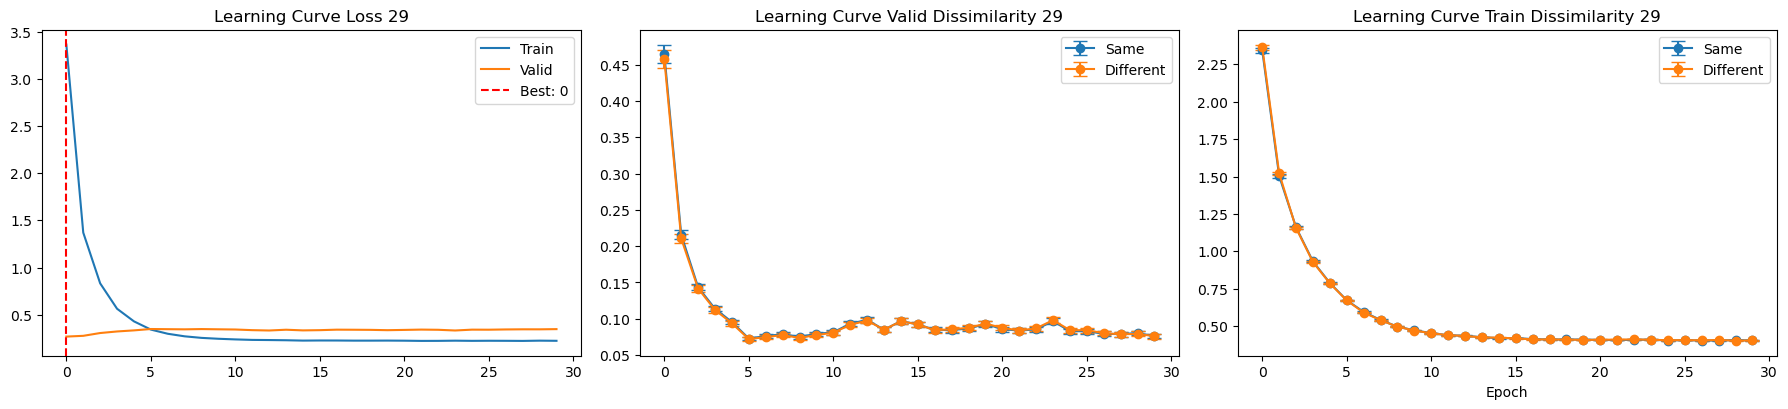

<Figure size 640x480 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

<Figure size 1800x400 with 0 Axes>

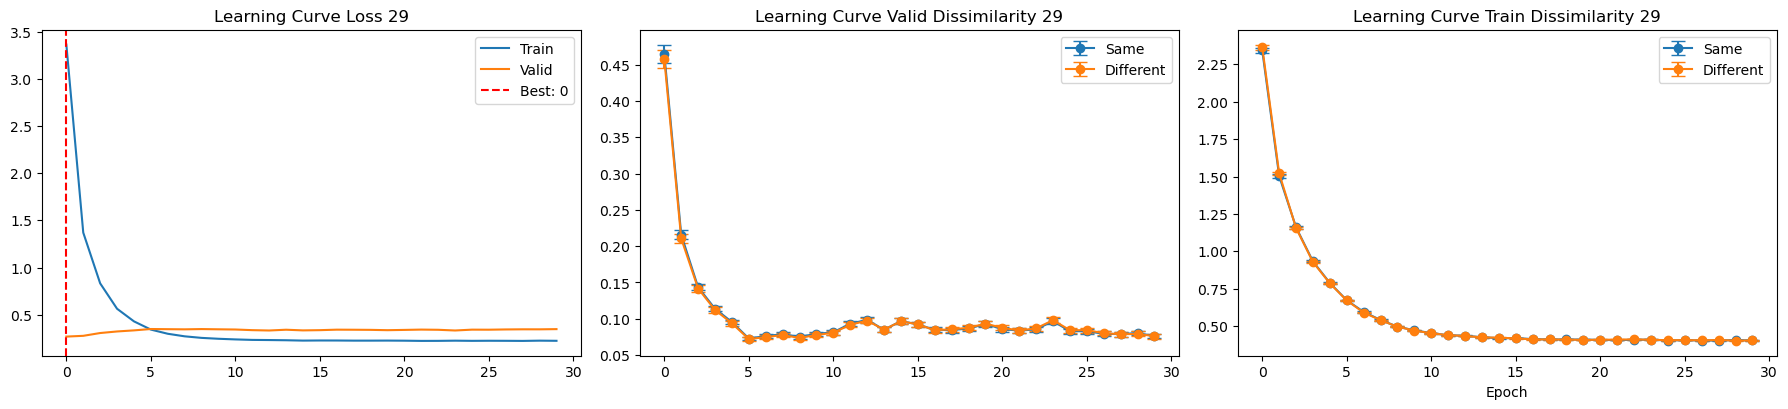

In [44]:
if __name__ == "__main__": 
    best_valid_loss, best_valid_loss_epoch = train(best_valid_loss, best_valid_loss_epoch)
    draw_learning_curve_and_dissimilarity(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                        dissimilarities=(train_same.get(), train_diff.get(), valid_same.get(), valid_diff.get(), (0, BASE + EPOCHS)),
                                        epoch=str(BASE + EPOCHS - 1), 
                                        save=True, 
                                        save_name=f"{model_save_dir}/vis.png")